<a href="https://colab.research.google.com/github/vicdlp/Complex-Networks/blob/main/Complex_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt


# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8')

# Set the fontsize for various plot elements
plt.rcParams.update({
    'font.size': 20,            # General font size
    'axes.titlesize': 22,       # Title font size
    'axes.labelsize': 20,       # Axis label font size
    'xtick.labelsize': 18,      # X-tick label font size
    'ytick.labelsize': 18,      # Y-tick label font size
    'legend.fontsize': 16,      # Legend font size
    'figure.figsize': (12, 8),  # Set default figure size
    'legend.frameon': True,
    'legend.edgecolor' : '0.1',
})

# Task 1 Generating the graph

In [3]:
class config_graph:
    def __init__(self, N, pi):
        self.N = N
        self.pi = pi
        self.degrees = np.zeros(self.N)
        self.stubs = []
        self.edges = []
        self.graph_dict = {}


    def generate_degree_sequence(self):
        while True:
            for i in range(self.N):
                if random.random() < self.pi:
                    self.degrees[i] = 4  # Degree 4 with probability pi
                else:
                    self.degrees[i] = 1  # Degree 1 with probability 1 - pi
            if sum(self.degrees) % 2 == 0: # checking that the sum of all degrees is even (it should be equal to 2M)
                break
            else:
                continue


    def generate_stubs(self):
        self.generate_degree_sequence()
        for i in range(self.N):
            self.stubs.extend(int(self.degrees[i]) * [i])

    def pair_stubs(self):
        self.generate_stubs()
        while True:
          random.shuffle(self.stubs)
          for i in range(0, len(self.stubs)-1, 2):
              u = self.stubs[i]
              v = self.stubs[i+1]
              if u == v:
                  # print("self edge error")
                  continue
              if (u, v) in self.edges and (v, u) in self.edges:
                  # print("double edge error")
                  continue

              self.edges.append((u, v))
          # print("correct graph done")
          break

    def neighbours(self, i):
        neighbours = []
        for edge in self.edges:
            if edge[0] == i:
                neighbours.append(edge[1])
            elif edge[1] == i:
                neighbours.append(edge[0])
        return neighbours

    def nb_dict(self):
        for i in range(self.N):
            self.graph_dict[i] = self.neighbours(i)


# Task 2 Giant connected component

Rest of the code and graphs of task 2 and 3 were made by Loumi Gatouillat


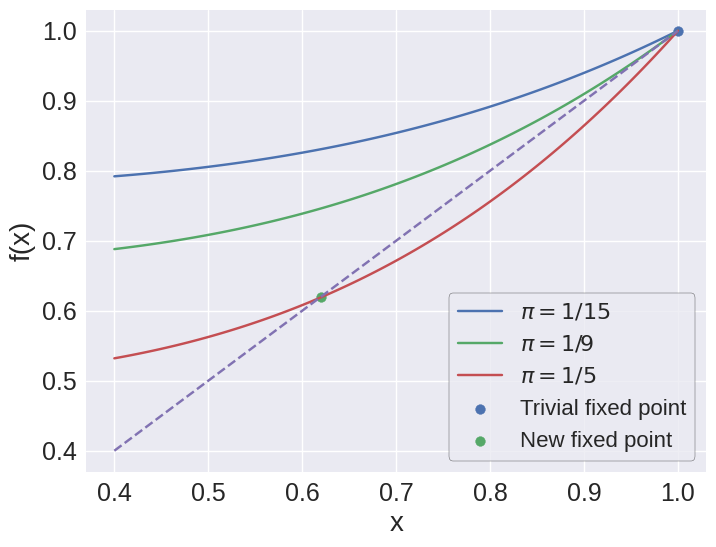

In [ ]:
def f(x, pi):
    return (1-pi + 4*pi*x**3)/(1+3*pi)


X = np.linspace(0.4, 1, 100)

plt.figure(figsize=(8, 6))
plt.plot(X, f(X, 1/15), label=r'$\pi = 1/15$')
plt.plot(X, f(X, 1/9), label=r'$\pi = 1/9$')
plt.plot(X, f(X, 1/5), label=r'$\pi = 1/5$')

plt.plot(X, X, '--', label = "")
plt.scatter(1, 1, label = "Trivial fixed point")
plt.scatter(0.62, 0.62, label = "New fixed point")

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()



# Task 4 Ising model on Configurational graph

We start by creating a class that has all the attributes of our set of graphs : Number of vertices $N$, connectivity $\pi$, a degree sequence, a set of edges, and also a dictionary with the neighbors of each vertex.


### A) Monte Carlo Markov Chains simulations

Now we create a class that has all the attributes of the previous one, but also has spins (initialized randomly) at each vertex. We also define functions like energy, magnetization, and MCMC_step.

The idea behind MCMC, is that instead of computing the average magnetization for example (which would be impossible as we don't know the probabilities of each microstate), we define a stochastic process on the graph, and if it obeys ergodicity, it should give the same magnetization when averaged over time steps. However, we want to compute the magnetization at equilibrium, which means when the process is stationary. One way to characterize the stationarrity of a time series is the weak stationarity, which is that the series is weakly stationary if its mean and variance are constant. So in order to make measurements of the magnetization, we first need to make sure that the process has reached stationarity.

In [6]:
from numba import jit
from numba.typed import Dict, List
from numba.core.types import ListType, intp


@jit(nopython = True) # Using numba to go faster
def MCMC_numba(N, s, beta, graph_dict):
    i = random.randint(0, N-1) # choosing a random vertex

    # Computing the energy difference if it was flipped
    H_old = 0
    for j in graph_dict[i]:
        H_old -= s[i] * s[j]
    H_new = -H_old

    p = np.exp(-beta * (H_new - H_old)) # acceptance probability
    if random.random() < p:
        s[i] = -s[i] # spin flip
    else:
        s[i] = s[i] # no spin flip

    return s



class Ising_graph(config_graph):

    def __init__(self, N, pi):
        super().__init__(N, pi)
        self.s = np.random.randint(0, 2, self.N) * 2 - 1 # Starting from a random configuration to speed up the thermalisation
        self.pair_stubs()
        self.nb_dict()
        self.numba_dict = Dict.empty(key_type=intp, value_type=ListType(intp)) # For numba compatibility
        for i, j in self.graph_dict.items():
            self.numba_dict[i] = List(j)

    def magnetization(self):
        return np.sum(self.s)/self.N

    def energy(self):
        H = 0
        for edge in self.edges:
            H -= self.s[edge[0]] * self.s[edge[1]]
        return H

    def local_energy(self, i): # Contribution to the energy of spin i
        H = 0
        for j in self.graph_dict[i]:
            H -= self.s[i] * self.s[j]
        return H/2

    def MCMC_step(self, beta):
        self.s = MCMC_numba(self.N, self.s, beta, self.numba_dict)



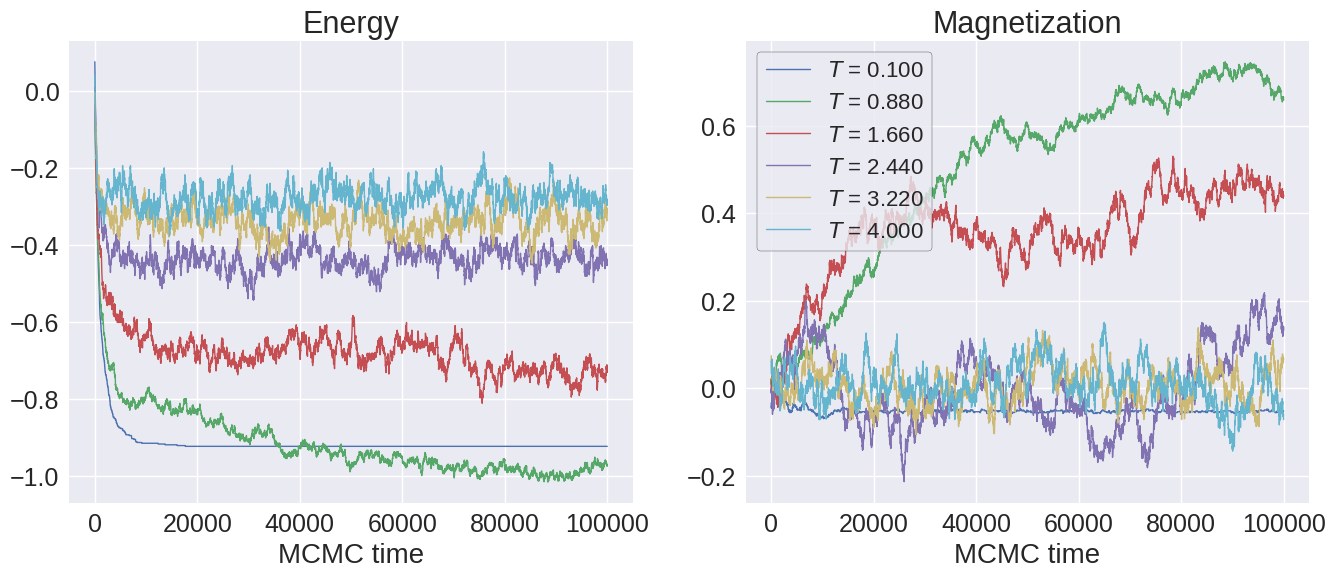

In [30]:
def simulation(N, pi, plot, T_list, steps = 200000): # Function to plot the energy and magnetization as of function of the number of steps of the MCMC algorithm, for differnet values of temperature

    graph = Ising_graph(N, pi) # creating a graph

    if plot == True:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    order_param = [] # List to store the average magnetization after thermalization for each temperature
    for Temp in T_list:
        graph.s = np.random.randint(0, 2, graph.N) * 2 - 1 # Random initialization of the spins
        E = []
        M =[]
        t = []
        beta = 1/Temp
        for i in range(steps):
            graph.MCMC_step(beta)
            if i % int(N/100) == 0:
                t.append(i)
                E.append(graph.energy()/graph.N)
                M.append(graph.magnetization())

        if plot == True:
            axs[0].plot(t,E, label = r"$T$ = %.3f" %(Temp), linewidth = 1)
            axs[0].set_title('Energy')
            axs[0].set_xlabel("MCMC time")
            axs[1].plot(t,M, label = r"$T$ = %.3f" %(Temp), linewidth = 1)
            axs[1].set_title('Magnetization')
            axs[1].set_xlabel("MCMC time")
        order_param.append(abs(np.mean(M[int(len(M)*0.70):]))) # averaging over the last 30% of the list, to only keep the measurements done in the thermalized state

    if plot == True:
        plt.legend()
        plt.show()

    return order_param

T_values = np.linspace(0.1, 4, 6)
M = simulation(1000, 0.4, True, T_values, 100000)




Starting from a random initial condition, the energy is around zero, then the energy decreases to reach a stationary value. The same behaviour is observed for the magnetization, but with three temperature being centered around zero and the three lowest having a net magnetization. However, the closer to the transition you are, the longer it takes to thermalize. Therefore, measurements close to this transition are less precise.

In [11]:
def T_c(pi):
    return 1/np.arctanh((1+3*pi)/(12*pi))

pi = 0.00
pi = 0.05
pi = 0.11
pi = 0.16
pi = 0.21
pi = 0.26
pi = 0.32
pi = 0.37
pi = 0.42
pi = 0.47
pi = 0.53
pi = 0.58
pi = 0.63
pi = 0.68
pi = 0.74
pi = 0.79
pi = 0.84
pi = 0.89
pi = 0.95
pi = 1.00


<ipython-input-5-7817f2631ec4>:2: RuntimeWarning: divide by zero encountered in divide
  return 1/np.arctanh((1+3*pi)/(12*pi))
<ipython-input-5-7817f2631ec4>:2: RuntimeWarning: divide by zero encountered in arctanh
  return 1/np.arctanh((1+3*pi)/(12*pi))
<ipython-input-5-7817f2631ec4>:2: RuntimeWarning: invalid value encountered in arctanh
  return 1/np.arctanh((1+3*pi)/(12*pi))


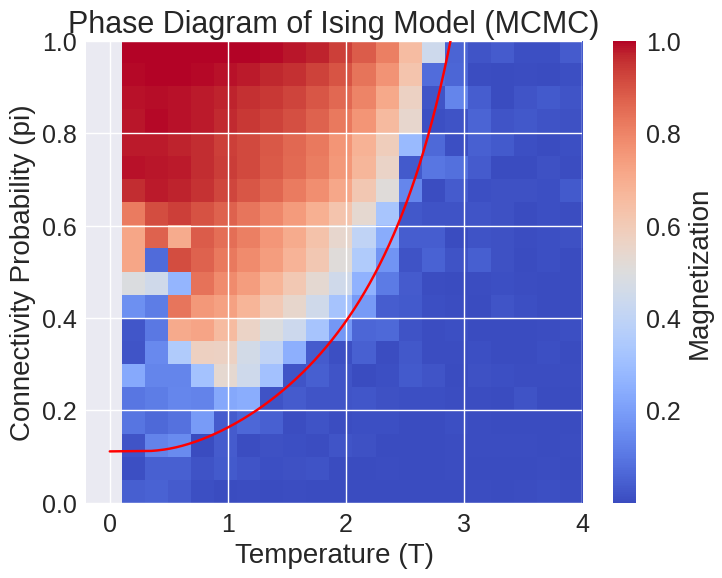

In [33]:
N = 1000

pi_values = np.linspace(0, 1, 20) # values of pi
T_values = np.linspace(0.1, 4, 20) # values of Temperature
phase_diagram = np.zeros((len(pi_values), len(T_values))) # 2d array


for i in range(len(pi_values)): # for each connectivity
    print("pi = %.2f" %(pi_values[i]))
    phase_diagram[i, :] = simulation(N, pi_values[i], False, T_values, steps = 400000) # Compute the magnetization (its absolute value actually) for different temperatures



plt.figure(figsize=(8, 6)) # plot of the result

plt.imshow(phase_diagram, origin='lower', aspect='auto',
           extent=[T_values.min(), T_values.max(), pi_values.min(), pi_values.max()],
           cmap='coolwarm')
plt.plot(T_c(np.linspace(0, 1, 1000)), np.linspace(0, 1, 1000), 'r-')
plt.colorbar(label="Magnetization")
plt.xlabel("Temperature (T)")
plt.ylabel("Connectivity Probability (pi)")
plt.title("Phase Diagram of Ising Model (MCMC)")
plt.show()

We can clearly see two phases. At low connectivity, there is no giant component, so there cannot be a net magnetization. Slightly above, there is a giant component, so a net magnetization appears. At the same time, at low temperatures, the MCMC algorithm takes a lot longer to reach stationarity, thus measurement are less accurate.

We could also make an histogram of the spins for different temperatures.

In [34]:
def histogram(N, pi, T_list, plot, steps = 1000):

      n_th = 20 # average number of steps per site to thermalize
      n_obs = int(N/10) # number of steps between data observations
      N_graphs = 20 # number of resettings of the graph

      M = np.zeros((len(T_list), steps*N_graphs))
      graph = Ising_graph(N, pi)

      for j in range(len(T_list)):
          beta = 1/T_list[j]
          for k in range(N_graphs):
                graph.s = np.random.randint(0, 2, graph.N) * 2 - 1

                for i in range(int(n_th*N*beta)):
                    graph.MCMC_step(beta)

                for i in range(steps*n_obs):
                    graph.MCMC_step(beta)
                    if i % n_obs:
                        M[j, k*steps + i//n_obs] = graph.magnetization()


      if plot == True:
          bins = np.linspace(-1, 1, 100)

          fig, axes = plt.subplots(len(T_list), 1, figsize=(12, 1.5*len(T_list)))

          for i, T in enumerate(T_list):
                axes[i].hist(M[i, :], bins=bins, label = r"$T = %.2f$" %(T), density = True)
                axes[i].set_title(r"Histogram for $\pi = %.3f$" %(pi))
                axes[i].legend()

          plt.tight_layout()
          plt.show()

      return M

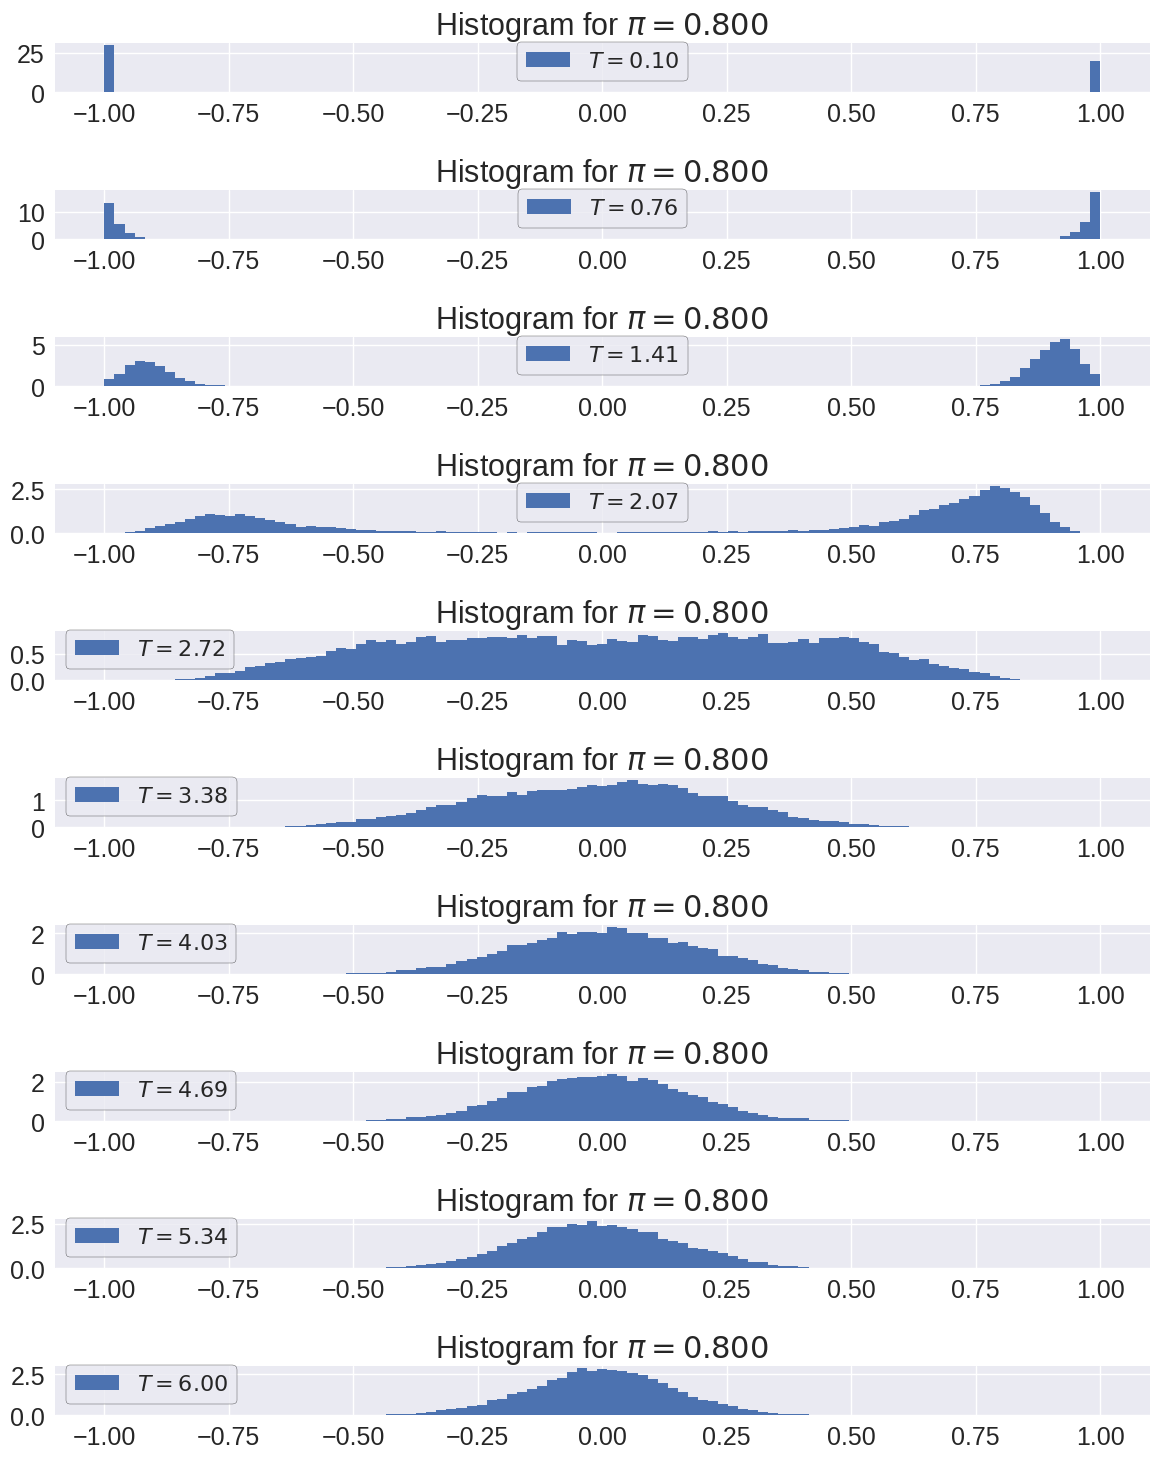

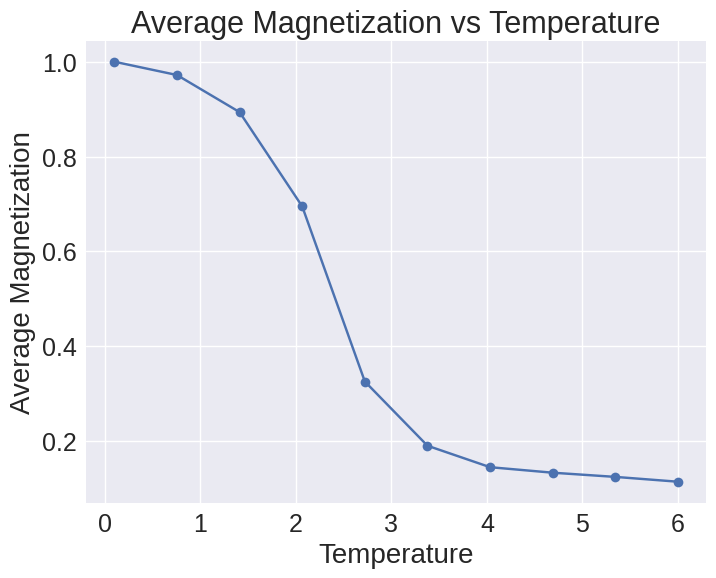

In [35]:
T_values = np.linspace(0.1, 6, 10)

M_100 = histogram(100, 0.8, T_values, True)

# Plot the line-wise average of M as a function of beta_list

M_avg_100 = np.mean(np.abs(M_100), axis=1)

beta_list = np.linspace(0.1, 10, 5)

plt.figure(figsize=(8, 6))
plt.plot(T_values, M_avg_100, marker='o')
plt.xlabel("Temperature")
plt.ylabel("Average Magnetization")
plt.title("Average Magnetization vs Temperature")
plt.show()


### B) Belief Propagation

Another approach is to compute observables through a message passing algorithm.



In [7]:
class BP_graph(config_graph):
    def __init__(self, N, pi):
        super().__init__(N, pi) # initialising a random graph of size N and connectivity pi
        self.pair_stubs() # generating a degree sequence and creating a compatible set of edges
        self.nb_dict() # creating a dictio
        self.cavity_fields = {}
        for i in range(self.N):
            self.cavity_fields[i] = np.random.normal(0, 0.1, (len(self.graph_dict[i])) )
        self.effective_fields = np.zeros(self.N)


    def BP_step(self, beta):
      for i in range(self.N):
          for j in range(len(self.graph_dict[i])):
              h_ij = 0
              n_ij = self.graph_dict[i][j]
              for k in range(len(self.graph_dict[n_ij])):
                  if self.graph_dict[n_ij][k] != i:
                      h_ij += np.log(np.cosh(beta*(self.cavity_fields[n_ij][k] + 1)) / np.cosh( beta*(self.cavity_fields[self.graph_dict[i][j]][k] - 1)  ) )

              self.cavity_fields[i][j] = h_ij/(2*beta)
          self.effective_fields[i] = 0
          for j in range(len(self.graph_dict[i])):
              self.effective_fields[i] += np.log(np.cosh(beta*(self.cavity_fields[i][j] + 1)) / np.cosh( beta*(self.cavity_fields[i][j] - 1)  ) )/(2*beta)


    def p_h(self):
        h = []
        for i in range(self.N):
            h.extend(self.cavity_fields[i])
        plt.figure(figsize=(8, 6))
        plt.hist(h, bins=41, density=True)
        plt.xlabel("Cavity Field")
        plt.ylabel("Probability Density")
        plt.title("Histogram of Cavity Fields")
        plt.show()
        plt.figure(figsize=(8, 6))
        plt.hist(self.effective_fields, bins=41, density=True)
        plt.xlabel("Effective Field")
        plt.ylabel("Probability Density")
        plt.title("Histogram of Effective Fields")
        plt.show()

    def magnetization(self, beta):
        m = np.tanh(beta*self.effective_fields)
        plt.figure(figsize=(8, 6))
        plt.hist(m, bins=41, density=True)
        plt.xlabel("Magnetization")
        plt.ylabel("Probability Density")
        plt.title("Histogram of Magnetization")
        plt.show()
        return m

    def order_param(self, beta):
        m = np.tanh(beta*self.effective_fields)
        return abs(np.mean(m))




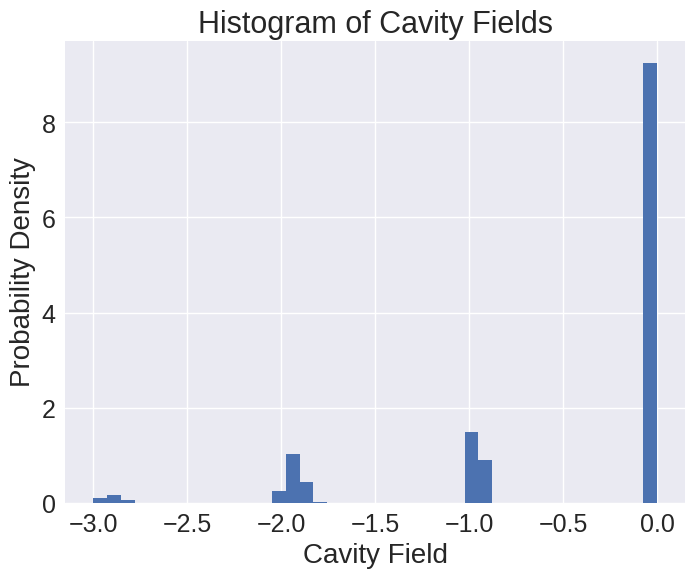

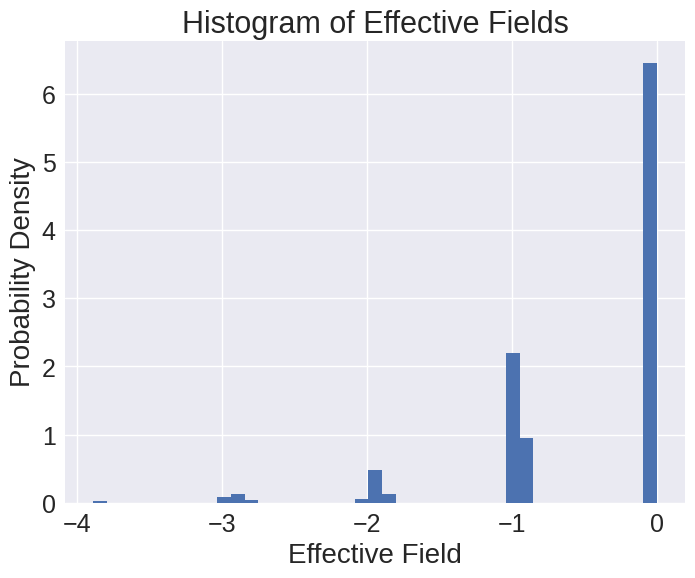

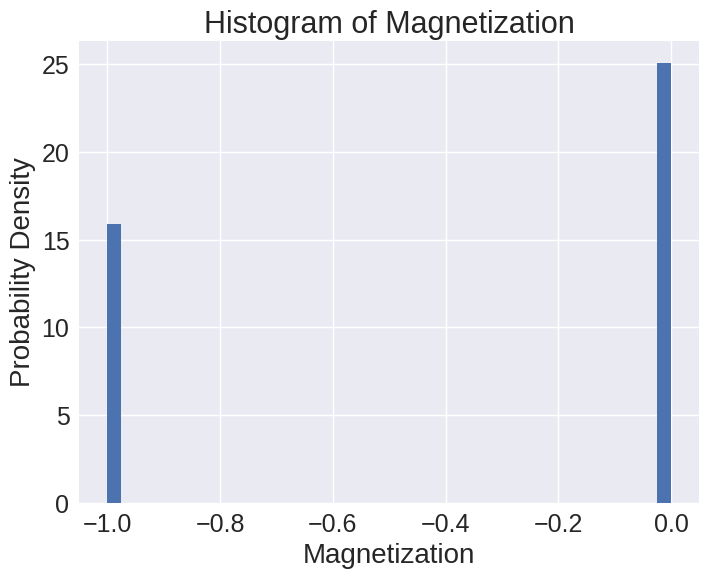

In [9]:
graph = BP_graph(1000, 0.2)
beta = 10
for i in range(1000):
    graph.BP_step(beta)
graph.p_h()
m = graph.magnetization(beta)



In [ ]:
T_values = np.linspace(0.1, 4, 20)
pi_values = np.linspace(0, 1, 20)
M = np.zeros((len(pi_values), len(T_values)))

for i in range(len(pi_values)):
    pi = pi_values[i]
    print("pi = %.2f" %(pi))
    graph = BP_graph(100, pi)
    for j in range(len(T_values)):
        Temp = T_values[j]
        beta = 1/Temp
        for k in range(1000):
            graph.BP_step(beta)

        M[i, j] = graph.order_param(beta)

plt.figure(figsize=(8, 6))
plt.imshow(M, origin='lower', aspect='auto',
           extent=[T_values.min(), T_values.max(), pi_values.min(), pi_values.max()],
           cmap='coolwarm')

plt.plot(T_c(np.linspace(0, 1, 1000)), np.linspace(0, 1, 1000), 'r-')
plt.colorbar(label="Magnetization")
plt.xlabel("Temperature (T)")
plt.ylabel("Connectivity Probability (pi)")
plt.title("Phase Diagram of Ising Model (BP)")
plt.show()

pi = 0.00
pi = 0.05
pi = 0.11
pi = 0.16
pi = 0.21
pi = 0.26
pi = 0.32
pi = 0.37
pi = 0.42
pi = 0.47
pi = 0.53
pi = 0.58
pi = 0.63
pi = 0.68
pi = 0.74
pi = 0.79
pi = 0.84


The phase diagram is different, especially in the high connectivity (higher part) of the plot. This is because, BP struggles with loopy graph, and at higher connectivity, there is more and more loops. However, the ferromagnetic phase occurs at higher connectivity, when the giant component emerges, therefore this approach is not very useful in practice

### C) Population Dynamics



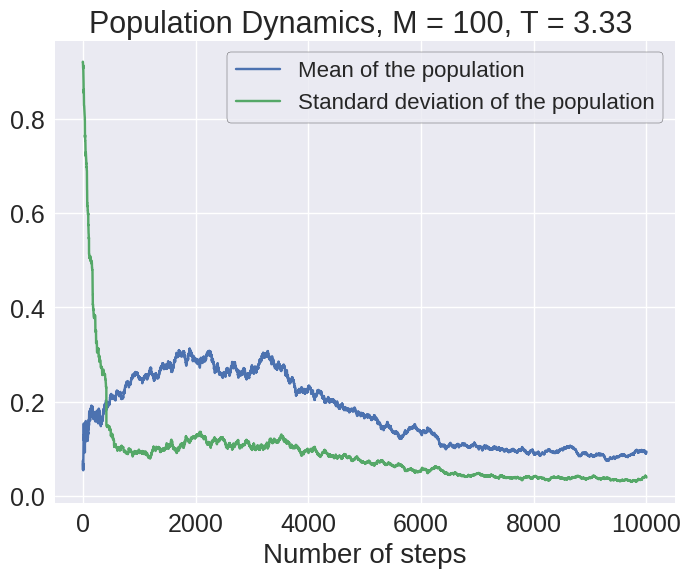

In [78]:
class population_graph(BP_graph):
    def __init__(self, N, pi):
        super().__init__(N, pi)
        self.pair_stubs()
        self.nb_dict()

        self.M = 100

        self.population = np.random.normal(0,1,self.M)

    def update_population(self, beta):
        p = 4*self.pi/(1+3*self.pi)

        if np.random.rand() < p:
            d = 4
        else:
            d = 1

        i = np.random.choice(self.M, d+1, replace = False)

        h = 0
        for l in range(1,d+1):
            h += np.log(np.cosh(beta*(self.population[i[l]] + 1)) / np.cosh( beta*(self.population[i[l]] - 1)  ) )/(2*beta)

        self.population[i[0]] = h


    def simulation(self, steps, beta, plot):


        h = []
        std = []

        for i in range(steps):
            self.update_population(beta)
            h.append(np.mean(self.population))
            std.append(np.std(self.population))

        if plot == True:
            plt.figure(figsize=(8, 6))
            plt.plot(h, label = "Mean of the population")
            plt.plot(std, label = "Standard deviation of the population")
            plt.xlabel("Number of steps")
            plt.title("Population Dynamics, M = %i, T = %.2f " %(self.M, 1/beta))
            plt.legend()
            plt.show()

    def termination(self, beta):
        m = 0
        for i in range(self.M):
            if random.random() < self.pi:
                d = 4
            else:
                d = 1

            i = np.random.choice(self.M, d, replace = False)

            h = 0

            for l in range(d):
                h += np.log(np.cosh(beta*(self.population[i[l]] + 1)) / np.cosh( beta*(self.population[i[l]] - 1)  ) )/(2*beta)

            m += np.tanh(beta*h)

        return m/self.M

PD_graph = population_graph(1000, 0.5)

PD_graph.simulation(10000, 0.3, True)



pi = 0.00
pi = 0.05
pi = 0.11
pi = 0.16
pi = 0.21
pi = 0.26
pi = 0.32
pi = 0.37
pi = 0.42
pi = 0.47
pi = 0.53
pi = 0.58
pi = 0.63
pi = 0.68
pi = 0.74
pi = 0.79
pi = 0.84
pi = 0.89
pi = 0.95
pi = 1.00


<ipython-input-11-7817f2631ec4>:2: RuntimeWarning: divide by zero encountered in divide
  return 1/np.arctanh((1+3*pi)/(12*pi))
<ipython-input-11-7817f2631ec4>:2: RuntimeWarning: divide by zero encountered in arctanh
  return 1/np.arctanh((1+3*pi)/(12*pi))
<ipython-input-11-7817f2631ec4>:2: RuntimeWarning: invalid value encountered in arctanh
  return 1/np.arctanh((1+3*pi)/(12*pi))


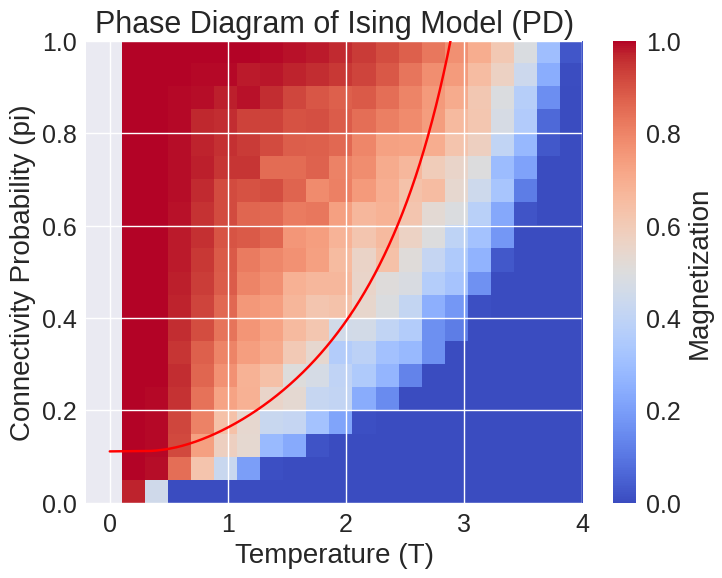

In [79]:
pi_values = np.linspace(0, 1, 20)
T_values = np.linspace(0.1, 4, 20)

M = np.zeros((len(pi_values), len(T_values)))

for i in range(len(pi_values)):
    pi = pi_values[i]
    print("pi = %.2f" %(pi))
    graph = population_graph(100, pi)
    for j in range(len(T_values)):
        Temp = T_values[j]
        beta = 1/Temp
        for k in range(10000):
            graph.update_population(beta)

        M[i, j] = abs(graph.termination(beta))

plt.figure(figsize=(8, 6))
plt.imshow(M, origin='lower', aspect='auto',
           extent=[T_values.min(), T_values.max(), pi_values.min(), pi_values.max()],
           cmap='coolwarm')

plt.plot(T_c(np.linspace(0, 1, 1000)), np.linspace(0, 1, 1000), 'r-')
plt.colorbar(label="Magnetization")
plt.xlabel("Temperature (T)")
plt.ylabel("Connectivity Probability (pi)")
plt.title("Phase Diagram of Ising Model (PD)")
plt.show()

# Task 5 Graph inference

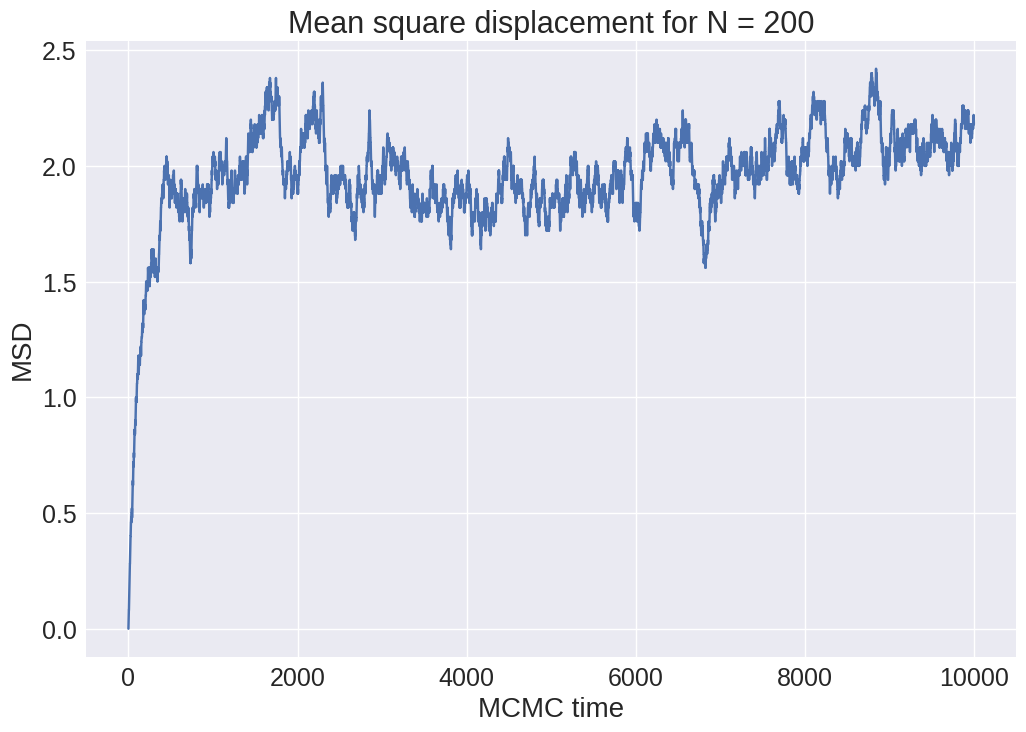

In [80]:
def MSD(x, y):
    return np.mean(np.square(x - y))

def graph_samples(M, delta_t):

    N = 200
    pi = 0.5
    beta = 0.3

    graph = Ising_graph(N, pi)

    data = np.zeros((M, N))

    for i in range(M):
        for j in range(delta_t):
            graph.MCMC_step(beta)

        data[i] = graph.s


    s_0 = data[0]
    C = np.ones(M)

    for t in range(M):
        s_t = data[t]
        C[t] = MSD(s_0, s_t)

    plt.figure()
    plt.plot(C)
    plt.title("Mean square displacement for N = 200")
    plt.xlabel("MCMC time")
    plt.ylabel("MSD")
    plt.show()

    return data, graph


samples, graph = graph_samples(10000, 1)




After about 2000 MCMC steps, samples can be considered independant.

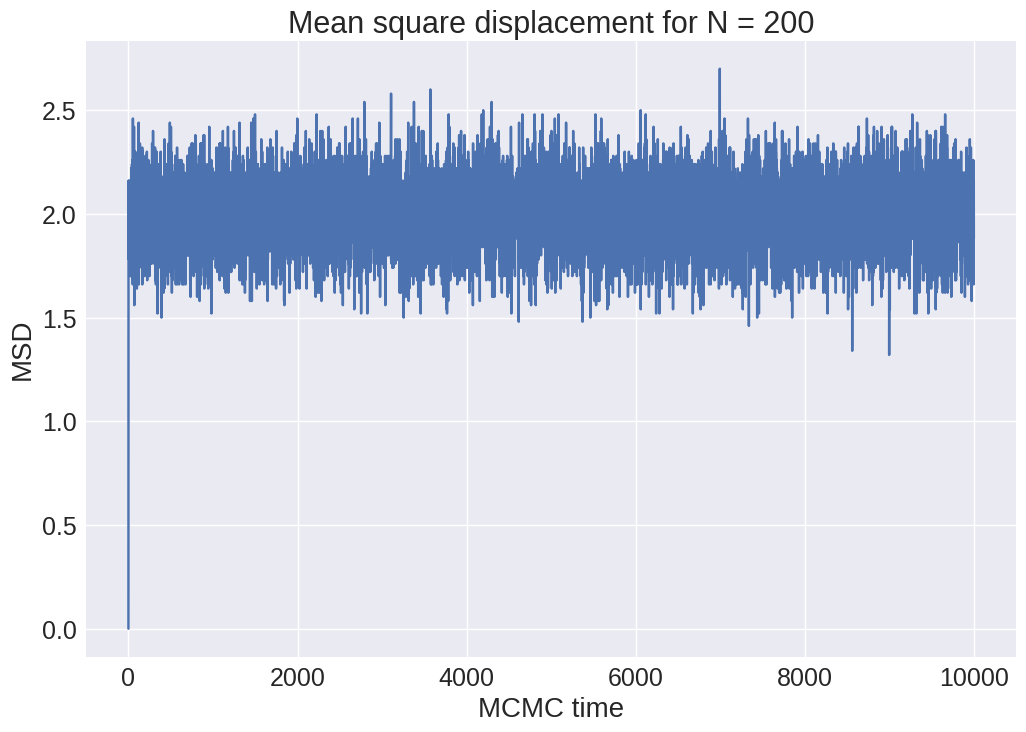

In [81]:
samples, graph = graph_samples(10000, 2000)

Our 10000 samples are indeed iid

In [82]:
def freq(data):
    N = data.shape[1]  # Get the number of spins/sites (N)
    M = data.shape[0]  # Get the number of samples (M)

    f_i = np.zeros((N, 2))  # Array to store frequencies of +1 and -1 for each site
    f_ij = np.zeros((N, N, 2, 2))  # Array to store frequencies of state pairs

    for i in range(N):
        # Count frequencies of +1 and -1 for site i
        f_i[i, 0] = np.count_nonzero(data[:, i] == 1)  # Frequency of +1
        f_i[i, 1] = np.count_nonzero(data[:, i] == -1) # Frequency of -1

        for j in range(N):
            # Count frequencies of state pairs for sites i and j
            f_ij[i, j, 0, 0] = np.count_nonzero((data[:, i] == 1) & (data[:, j] == 1))  # Freq of (+1, +1)
            f_ij[i, j, 0, 1] = np.count_nonzero((data[:, i] == 1) & (data[:, j] == -1))  # Freq of (+1, -1)
            f_ij[i, j, 1, 0] = np.count_nonzero((data[:, i] == -1) & (data[:, j] == 1))  # Freq of (-1, +1)
            f_ij[i, j, 1, 1] = np.count_nonzero((data[:, i] == -1) & (data[:, j] == -1))  # Freq of (-1, -1)

    for i in range(N):
            for j in range(N):
                for s in range(2):
                    for t in range(2):
                        f_i_f_j = f_i[i, s] * f_i[j, t] / M**2

                        f_ij[i, j, s, t] = (f_ij[i, j, s, t] - f_i_f_j) / M
    return f_i/M, f_ij


In [83]:
f_i, f_ij = freq(samples)

In [84]:
def mutual_infor(f_ij, f_i):
    N = f_i.shape[0]
    M_ij = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            for s in range(2):
                for t in range(2):
                    M_ij[i, j] += f_ij[i, j, s, t] * np.log(f_ij[i, j, s, t] / (f_i[i, s] * f_i[j, t]))

    for i in range(N):
          M_ij[i, i] = 0

    return M_ij

In [85]:
M_ij = mutual_infor(f_ij, f_i)

<ipython-input-84-fd5099326543>:9: RuntimeWarning: invalid value encountered in log
  M_ij[i, j] += f_ij[i, j, s, t] * np.log(f_ij[i, j, s, t] / (f_i[i, s] * f_i[j, t]))


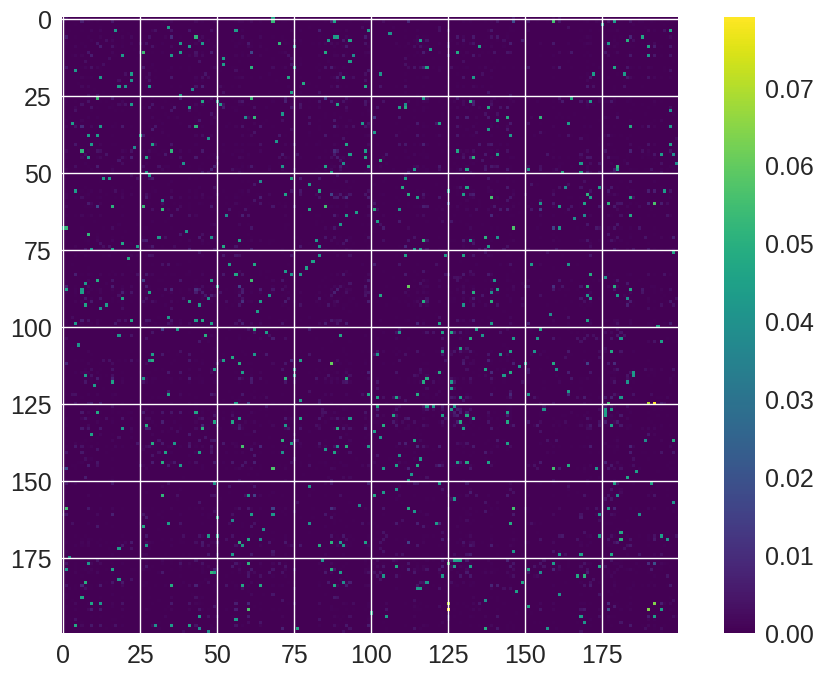

In [86]:
plt.imshow(M_ij, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [87]:
def rank_pairs(M_ij):

  N = M_ij.shape[0]
  ranked_pairs = []
  for i in range(N):
    for j in range(i + 1, N):  # Avoid redundancy (i, j) and (j, i)
      ranked_pairs.append((i, j, M_ij[i, j]))

  ranked_pairs.sort(key=lambda x: x[2], reverse=True)
  return ranked_pairs

ranked_pairs = rank_pairs(M_ij)

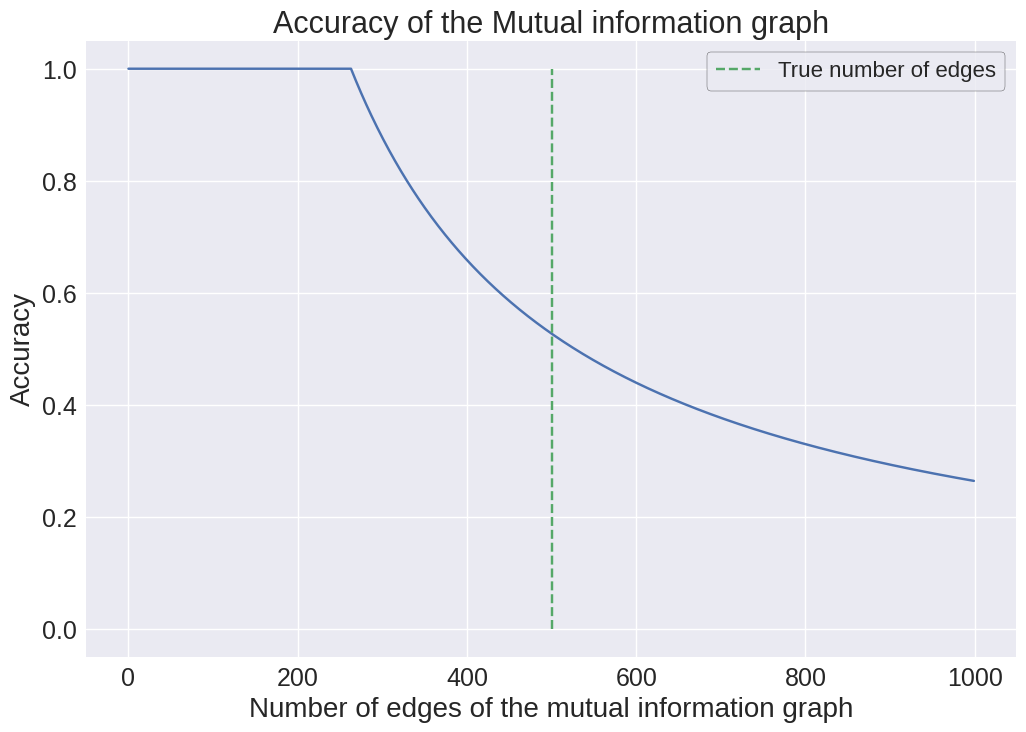

In [88]:
def true_positive(graph, ranked_pairs):
    TP = np.zeros((len(ranked_pairs)))
    k = 0
    for i in range(len(ranked_pairs)):
        u = ranked_pairs[i][0]
        v = ranked_pairs[i][1]
        if (u,v) in graph.edges or (v, u) in graph.edges:
            k += 1
        TP[i] = k/(i+1)
    return TP

TP = true_positive(graph, ranked_pairs)

plt.figure()
plt.plot(TP[:1000])
plt.plot([500, 500], [0, 1], '--', label = "True number of edges")
plt.xlabel("Number of edges of the mutual information graph")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Accuracy of the Mutual information graph")
plt.show()

In [89]:
def connected_correlation(f_ij):

  N = f_ij.shape[0]
  C_ij = np.zeros((N, N))

  for i in range(N):
    for j in range(N):
      C_ij[i, j] = f_ij[i, j, 0, 0] + f_ij[i, j, 1, 1] - (f_ij[i, j, 0, 1] + f_ij[i, j, 1, 0])


  return C_ij


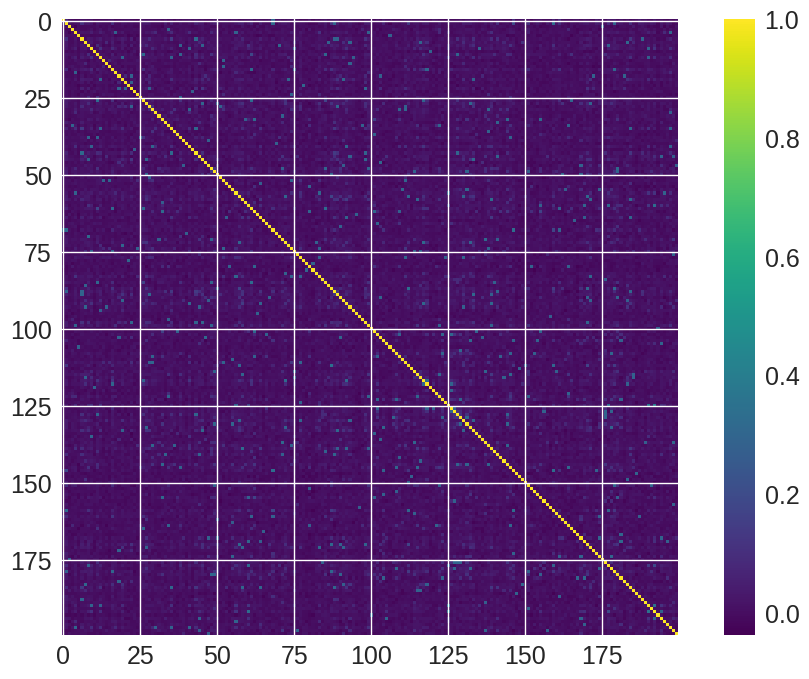

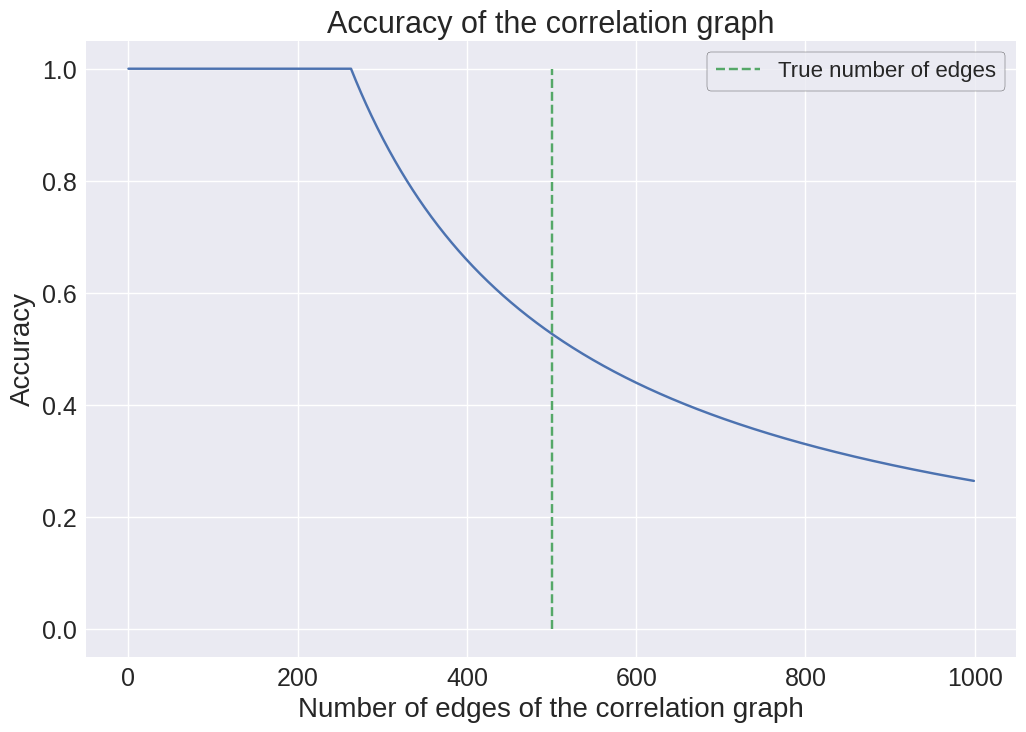

In [90]:
C_ij = connected_correlation(f_ij)

plt.imshow(C_ij, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

ranked_pairs = rank_pairs(C_ij)

TP = true_positive(graph, ranked_pairs)

plt.figure()
plt.plot(TP[:1000])
plt.plot([500, 500], [0, 1], '--', label = "True number of edges")
plt.xlabel("Number of edges of the correlation graph")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Accuracy of the correlation graph")
plt.show()

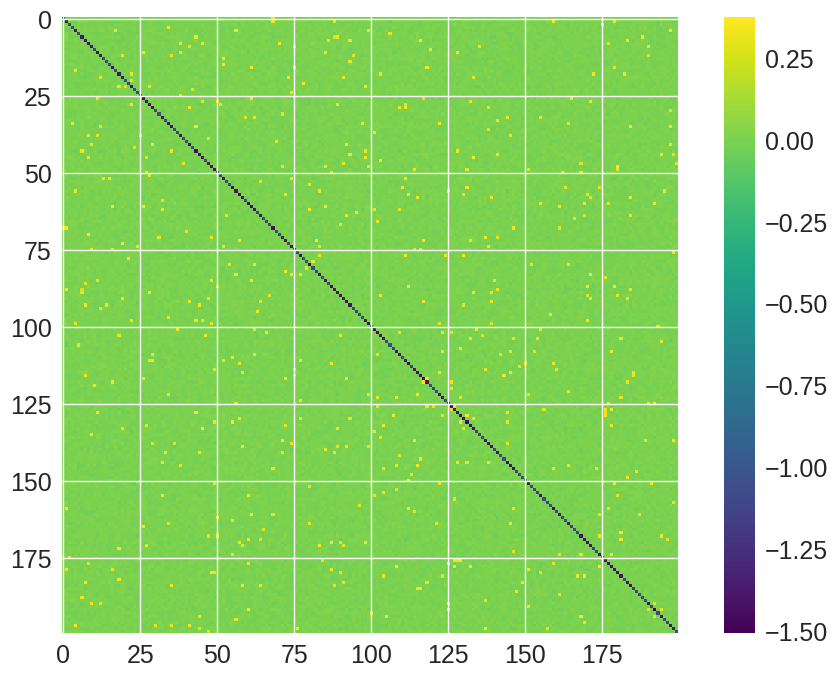

Text(0.5, 1.0, 'Accuracy of the Mean Field graph')

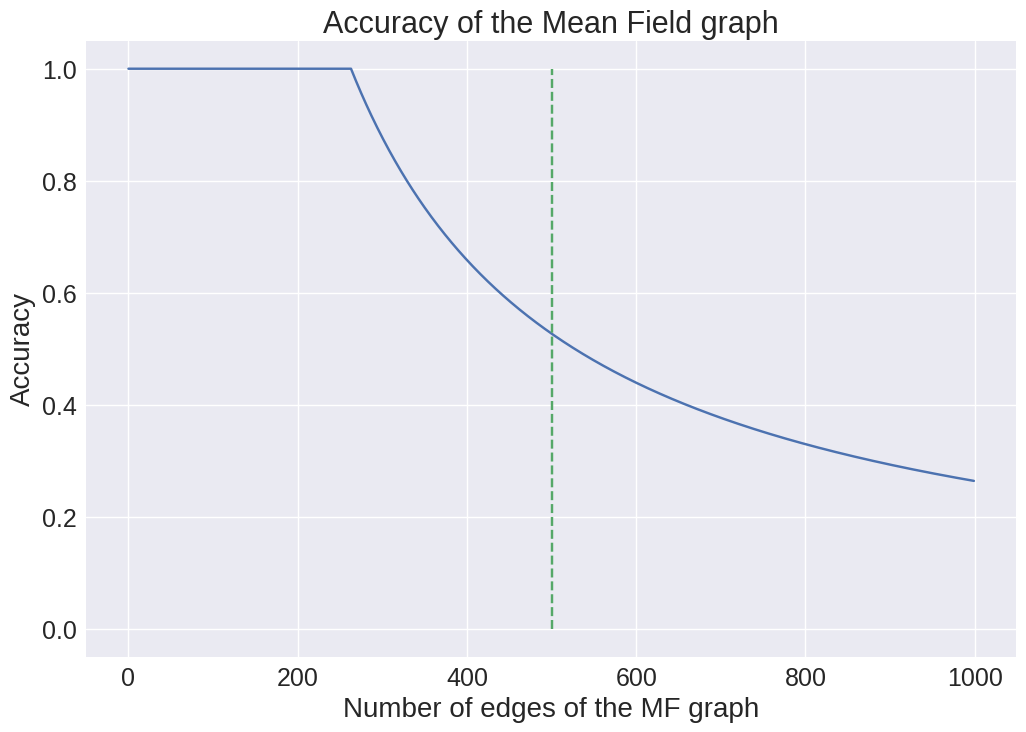

In [91]:
J_ij = -np.linalg.inv(C_ij)
plt.imshow(J_ij, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

ranked_pairs = rank_pairs(J_ij)
TP_MF = true_positive(graph, ranked_pairs)

plt.figure()
plt.plot(TP_MF[:1000])
plt.plot([500, 500], [0, 1], '--', label = "True number of edges")
plt.xlabel("Number of edges of the MF graph")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Mean Field graph")

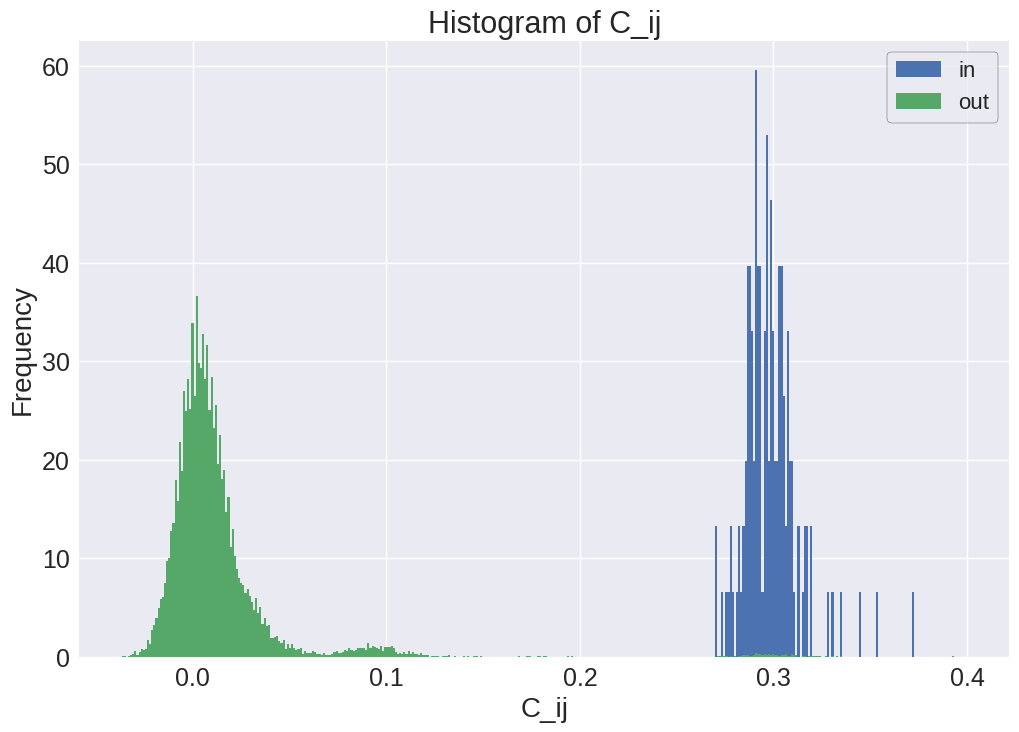

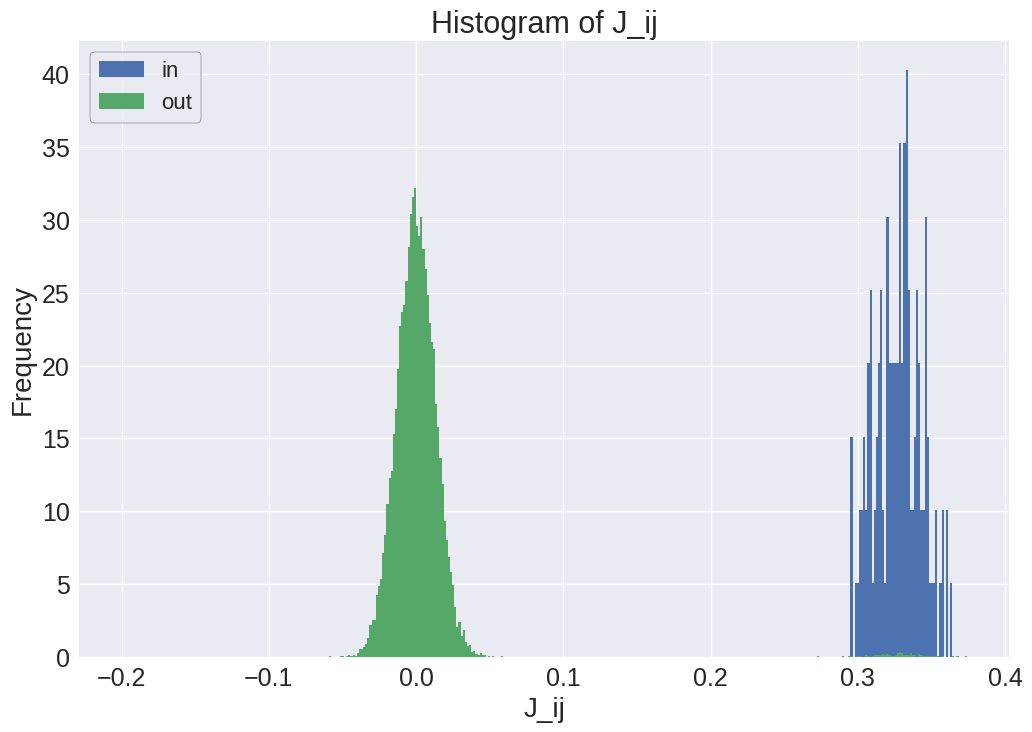

In [92]:
def in_out(C,J,edges):
    C_in = []
    J_in = []
    C_out = []
    J_out = []
    N = C.shape[0]
    for i in range(N):
        for j in range(i+1,N):
            if (i,j) in edges:
                C_in.append(C[i,j])
                J_in.append(J[i,j])
            else:
                C_out.append(C[i,j])
                J_out.append(J[i,j])
    return C_in,J_in,C_out,J_out

C_in, J_in, C_out, J_out = in_out(C_ij, J_ij, graph.edges)

bins = np.linspace(min(C_ij.flatten()), 0.4, 400)
plt.figure()
plt.hist(C_in, bins = bins, density=True, label = "in")
plt.hist(C_out, bins = bins, density=True, label = "out")
plt.title("Histogram of C_ij")
plt.xlabel("C_ij")
plt.ylabel("Frequency")
plt.legend()
plt.show()

bins = np.linspace(-0.2, max(J_ij.flatten()), 400)
plt.figure()
plt.hist(J_in, bins = bins, density=True, label = "in")
plt.hist(J_out, bins = bins, density=True, label = "out")
plt.title("Histogram of J_ij")
plt.xlabel("J_ij")
plt.ylabel("Frequency")
plt.legend()
plt.show()
